In [1]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
sns.set(style='whitegrid')

  ## 1. Load raw data

In [2]:

DATA_DIR = Path('/home/arjay55/code/datasets/diabetes+130-us+hospitals+for+years+1999-2008')  # change if files are elsewhere
df = pd.read_csv(DATA_DIR / 'diabetic_data.csv')
ids_map = pd.read_csv(DATA_DIR / 'IDS_mapping.csv')
print(f'Data shape: {df.shape}')
df.head()

Data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
def encode_med_change(x):
    """
    Simple ordinal encoder for medication‐change flags. No translates to zero as there is no drug. 
    Down can have the value of 1 as as the probability of relatively lower dosage than is more likely., 2 for steady meaning the drugs are normal,
    3 for up as the probability of relatively higher dosage than is more likely.
    
    Maps:
      "No"     → 0.0
      "Down"   → 1.0
      "Steady" → 2.0
      "Up"     → 3.0
    
    Anything else → np.nan
    """
    mapping = {
        "no":      0.0,
        "down":    1.0,
        "steady":  2.0,
        "up":      3.0,
    }
    # normalize to lower‐case string, then lookup
    return mapping.get(str(x).strip().lower(), np.nan)

In [4]:
# Apply medication change encoding to all medication columns
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

for col in medication_cols:
    df[col] = df[col].apply(encode_med_change)

print(f"Applied medication change encoding to {len(medication_cols)} columns")
print("Sample encoded values:")
print(df[medication_cols[:5]].head())
   

Applied medication change encoding to 23 columns
Sample encoded values:
   metformin  repaglinide  nateglinide  chlorpropamide  glimepiride
0        0.0          0.0          0.0             0.0          0.0
1        0.0          0.0          0.0             0.0          0.0
2        0.0          0.0          0.0             0.0          0.0
3        0.0          0.0          0.0             0.0          0.0
4        0.0          0.0          0.0             0.0          0.0


In [5]:
# Drop weight as 97% have missing weights and drop impossible genders
df = df[df['gender'] != 'Unknown/Invalid'].copy()
df.drop(columns=['weight'], inplace=True)
freq = df["patient_nbr"].value_counts(normalize=True) # Calculate frequency of each patient. More frequent patients are more likely to have chronic conditions.
df["patient_freq"] = df["patient_nbr"].map(freq)



# Drop patient_nbr as it is not useful for modeling anymore
df.drop(columns=['patient_nbr'], inplace=True)

# Replace '?' with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')

# Remove encounters with discharge disposition indicating death/hospice
hospice_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(hospice_codes)]

# Convert discharge_disposition_id to categorical for better handling
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('category')

print('After cleaning:', df.shape)

After cleaning: (100111, 49)


  ### 2.1 Map admission/disposition/source IDs
  * Translates IDs to descriptions for easier analysis

In [6]:
# Create mapping for admission_type_id only (since that's what we have)
def build_mapping_from_df(df_map):
    # Remove any rows with NaN values
    df_clean = df_map.dropna()
    return dict(zip(df_clean['admission_type_id'], df_clean['description']))

# Build the admission type mapping
admission_type_mapping = build_mapping_from_df(ids_map)

original_dtype = df['admission_type_id'].dtype

# Create new mapping with converted keys
if original_dtype in ['int64', 'int32', 'float64']:
    # Convert string keys to numeric
    admission_type_mapping_fixed = {
        int(k): v for k, v in admission_type_mapping.items() 
        if k.isdigit()
    }
else:
    # Keep as strings
    admission_type_mapping_fixed = admission_type_mapping

# Apply the mapping
df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping_fixed).fillna('Other')

print("After applying mapping with converted keys:")
print(df['admission_type_id'].value_counts())

After applying mapping with converted keys:
admission_type_id
 Physician Referral                                52882
HMO Referral                                       18738
Clinic Referral                                    18226
 Transfer from another health care facility         5227
 Transfer from a Skilled Nursing Facility (SNF)     4690
 Court/Law Enforcement                               320
 Emergency Room                                       18
Transfer from a hospital                              10
Name: count, dtype: int64


  ### 2.2 Aggregate ICD‑9 diagnosis codes
* First if statement are focused on internal, coronary and diabetic diseases, which could have comorbidities with each other, and thus we choose to make this detailed.
* Other diseases are grouped, as they can have of less influence.

In [7]:

def diag_category(icd):
    try:
        icd = str(icd)
        code = icd.split('.')[0]  # take 3‑digit root
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code = int(code)
    except:
        return 'Other'
    if 390 <= code <= 459 or code == 785 or 460 <= code <= 519 or code == 786 or 520 <= code <= 579 or code == 787 or 250 <= code <= 251:
        return f'icd_{code}'  # will result to very sparse categories
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 140 <= code <= 239:
        return 'Neoplasms'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_cat'] = df[col].apply(diag_category)

df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

encounter_id has no relevance in the study

In [8]:

df.drop(columns=['encounter_id'], inplace=True, errors='ignore')

  ## 3. Train‑test split & preprocessing

In [9]:
def clean_column_name(col_name):
    """Clean column names by removing special characters that XGBoost doesn't allow"""
    return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_lt_').replace('>', '_gt_').replace(',', '_')

In [10]:

y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train, X_test, y_train, y_test = train_test_split( #stratified sampling
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))

# Fix column names to remove special characters that XGBoost doesn't allow
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Train size: (70077, 47) Pos rate: 0.113
Test size: (30034, 47) Pos rate: 0.113


  ### 3.1 Balance training set by random oversampling

In [11]:

train = pd.concat([X_train, y_train], axis=1)
maj = train[train['readmitted']==0]
minu = train[train['readmitted']==1]
minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=1803)
train_bal = pd.concat([maj, minu_upsampled])
X_train_bal = train_bal.drop(columns=['readmitted'])
y_train_bal = train_bal['readmitted']
print('Balanced class counts:', y_train_bal.value_counts())

Balanced class counts: readmitted
0    62127
1    62127
Name: count, dtype: int64


  ### 3.2 One‑hot encode categorical variables

In [12]:

# categorical features ("object" dtype) are dummified, meaning they are converted to one-hot encoded columns.
cat_feats = X_train_bal.select_dtypes(include=['object','category']).columns
X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True) # reduce collinearity
X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True) # reduce collinearity
X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

## haircut for it to be compatible with XGBoost
X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# Apply standard scaling to numeric features
num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats])
X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats])

print("Feature engineering for baseline runs completed.")
# Dummify categorical variables for X_train and X_test

print("Creating dummy variables for training and test sets for pipeline use...")

# Get categorical columns
cat_cols = X_train.select_dtypes(include=['object','category']).columns
print(f"Categorical columns to encode: {list(cat_cols)}")



# Dummify X_train and X_test
X_train = pd.get_dummies(X_train, columns=cat_feats, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)

scaler = StandardScaler() # normalize!
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test[num_feats] = scaler.transform(X_test[num_feats])
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Clean column names for XGBoost compatibility
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Feature engineering for baseline runs completed.
Creating dummy variables for training and test sets for pipeline use...
Categorical columns to encode: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat']


  ## 4. Model training

In [13]:

print("Initializing models...")
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=1803)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1803)
xgb = XGBClassifier(n_estimators=100, max_depth=6, eval_metric='logloss',
                    use_label_encoder=False, verbosity=0, random_state=1803)

print("Training Logistic Regression...")
logreg.fit(X_train_bal_enc, y_train_bal)
print("Training Random Forest...")
rf.fit(X_train_bal_enc, y_train_bal)
print("Training XGBoost...")
xgb.fit(X_train_bal_enc, y_train_bal)

Initializing models...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:

def eval_model(name, model):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:20} Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC: {auc:.3f} Accuracy: {acc:.3f}")
    return y_pred

preds = {}
preds['Logistic'] = eval_model('Logistic Regression', logreg)
preds['RandomForest'] = eval_model('Random Forest', rf)
preds['XGBoost'] = eval_model('XGBoost', xgb)

Logistic Regression  Precision: 0.221 Recall: 0.584 F1: 0.321 ROC-AUC: 0.726 Accuracy: 0.720
Random Forest        Precision: 0.203 Recall: 0.762 F1: 0.321 ROC-AUC: 0.742 Accuracy: 0.635
XGBoost              Precision: 0.238 Recall: 0.729 F1: 0.358 ROC-AUC: 0.781 Accuracy: 0.704


* Results show suboptimal performance. The class imbalance is significant, due to small positivity rate of 0.113.
* We will proceed with XGBOOST due to its versatility and a go-to algorithm for tabular data.
* We will use optuna as a hyperparameter tuning tool, a generic hyperparameter tuning framework.

In [15]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Create pipeline with proper order: preprocess -> balance -> model (with Optuna parameters)
def create_model_pipeline(trial=None):
    
    # If trial is provided, optimize hyperparameters
    if trial is not None:
        # Optuna hyperparameter suggestions for XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
        
        classifier = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            eval_metric='logloss',
            use_label_encoder=False,
            verbosity=0,
            random_state=1803,
            n_jobs=10  # Use all available cores
        )
    else:
        # Use default/best known parameters for XGBoost
        classifier = XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric='logloss', use_label_encoder=False,
            verbosity=0, random_state=1803
        )
    rng = np.random.default_rng()
    pipeline = ImbPipeline([ 
        ('balancer', SMOTE(random_state=rng.integers(2**16))), # pipeline performs oversampling per each fold, avoiding data leakage
        ('classifier', classifier)
    ])
    return pipeline

# Optuna objective function
def objective(trial):
    # Create pipeline with trial parameters
    pipeline = create_model_pipeline(trial)
    
    # Cross-validation with proper data handling

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=4,  
        scoring='accuracy',
        n_jobs=1  # Reduced to prevent system overload
    )
    
    return cv_scores.mean()

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

# Optimize with progress callback
# def callback(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")

study.optimize(
    objective, 
    n_trials=100,
    # callbacks=[callback],
    show_progress_bar=True,
)

# Print optimization results
print(f"\nOptimization completed!")
print(f"Best parameters: {study.best_params}")
print(f"Best CV accuracy score: {study.best_value:.4f}")

# Create final pipeline with best parameters
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")

[I 2025-06-21 11:13:20,157] A new study created in memory with name: no-name-57b9076e-58a8-4c17-ba35-2dc86832c8bf


Starting Optuna hyperparameter optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-21 11:13:50,606] Trial 0 finished with value: 0.8801746590329456 and parameters: {'n_estimators': 164, 'max_depth': 15, 'learning_rate': 0.21191694474081635, 'subsample': 0.6904437683143655, 'colsample_bytree': 0.8618698714066619, 'reg_alpha': 0.3962959879812257, 'reg_lambda': 0.909399760281288}. Best is trial 0 with value: 0.8801746590329456.
[I 2025-06-21 11:14:43,838] Trial 1 finished with value: 0.8800747886638929 and parameters: {'n_estimators': 309, 'max_depth': 13, 'learning_rate': 0.013593797341396345, 'subsample': 0.7425593088977969, 'colsample_bytree': 0.9273841019764437, 'reg_alpha': 0.3435138821068924, 'reg_lambda': 0.29783633190422765}. Best is trial 0 with value: 0.8801746590329456.
[I 2025-06-21 11:16:01,647] Trial 2 finished with value: 0.8787191347828229 and parameters: {'n_estimators': 513, 'max_depth': 14, 'learning_rate': 0.21957825505770912, 'subsample': 0.7201632969976054, 'colsample_bytree': 0.9336080058865639, 'reg_alpha': 0.3499472600676322, 'reg_lam

In [16]:
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params,random_state=1803)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")


Training final model with best parameters...
Final CV accuracy score: 0.887 ± 0.001


In [17]:
# Train the final model on all training data
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('balancer', SMOTE(random_state=19900)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8902215020820525, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.1053549221246748, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=833,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [18]:
# Evaluate on test set
y_pred_test = best_pipeline.predict(X_test)
y_prob_test = best_pipeline.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print(f"\nFinal Test Performance:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"F1: {test_f1:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

# Save the best model for later use
best_rf_optimized = best_pipeline.named_steps['classifier']


Final Test Performance:
Accuracy: 0.887
F1: 0.106
Precision: 0.533
Recall: 0.059
ROC-AUC: 0.784


* Accuracy was well achieved. However the lack of data for readmissions resulted in highly skewed result plus some other modeling imperfections. The model is not yet safe for deployment. A higher recall is better. Class weighting that biases on readmission rates will be better.

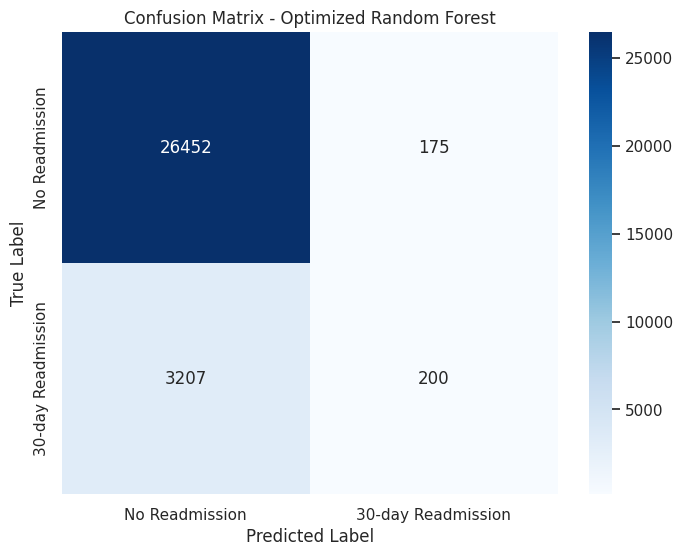

In [19]:

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")


Confusion Matrix:
True Negatives: 26452
False Positives: 175
False Negatives: 3207
True Positives: 200


In [21]:
study.best_params

{'n_estimators': 833,
 'max_depth': 3,
 'learning_rate': 0.1053549221246748,
 'subsample': 0.8579401133870473,
 'colsample_bytree': 0.8902215020820525,
 'reg_alpha': 0.9164761833474965,
 'reg_lambda': 0.5370497367741534}

# PyTorch Tabular Implementation

Now we'll implement the same training pipeline using PyTorch Tabular with neural networks instead of XGBoost. Pytorch Tabular aims to implement suitable neural network architectures for tabular data with ease of use in using other popular frameworks, like Pandas.

In [13]:
# Import PyTorch Tabular
import torch
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

print("PyTorch Tabular imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch Tabular imported successfully
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti


In [14]:
# Prepare data for PyTorch Tabular
# We'll use the same train/test split as XGBoost but with different preprocessing
print("Preparing data for PyTorch Tabular...")

# Start with the original X_train, X_test, y_train, y_test
# Reset from the original data before one-hot encoding
y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('PyTorch Tabular - Train size:', X_train_pt.shape, 'Pos rate:', y_train_pt.mean().round(3))
print('PyTorch Tabular - Test size:', X_test_pt.shape, 'Pos rate:', y_test_pt.mean().round(3))

# Clean column names
X_train_pt.columns = [clean_column_name(col) for col in X_train_pt.columns]
X_test_pt.columns = [clean_column_name(col) for col in X_test_pt.columns]

# Add target column to create complete datasets
train_df_pt = X_train_pt.copy()
train_df_pt['target'] = y_train_pt.values

test_df_pt = X_test_pt.copy()
test_df_pt['target'] = y_test_pt.values

print("Data prepared for PyTorch Tabular")

Preparing data for PyTorch Tabular...
PyTorch Tabular - Train size: (70077, 47) Pos rate: 0.113
PyTorch Tabular - Test size: (30034, 47) Pos rate: 0.113
Data prepared for PyTorch Tabular


In [15]:
# Balance training set by random oversampling (same as XGBoost)
print("Balancing training data...")

maj_pt = train_df_pt[train_df_pt['target']==0]
minu_pt = train_df_pt[train_df_pt['target']==1]
minu_upsampled_pt = resample(minu_pt, replace=True, n_samples=len(maj_pt), random_state=1803)
train_bal_df_pt = pd.concat([maj_pt, minu_upsampled_pt])

print('Balanced class counts for PyTorch Tabular:', train_bal_df_pt['target'].value_counts())
print('Balanced training set shape:', train_bal_df_pt.shape)

Balancing training data...
Balanced class counts for PyTorch Tabular: target
0    62127
1    62127
Name: count, dtype: int64
Balanced training set shape: (124254, 48)


In [16]:
# Define categorical and numerical columns for PyTorch Tabular
categorical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype == 'object' or X_train_pt[col].dtype.name == 'category']
numerical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype != 'object' and X_train_pt[col].dtype.name != 'category']

print(f"Categorical columns ({len(categorical_cols_pt)}): {categorical_cols_pt[:5]}...")
print(f"Numerical columns ({len(numerical_cols_pt)}): {numerical_cols_pt[:5]}...")

# Make sure we have the correct categoricals
categorical_cols_pt = []
numerical_cols_pt = []

for col in X_train_pt.columns:
    if X_train_pt[col].dtype == 'object' or str(X_train_pt[col].dtype) == 'category':
        categorical_cols_pt.append(col)
    else:
        numerical_cols_pt.append(col)

# Dummify categorical columns for PyTorch Tabular
X_train_pt = pd.get_dummies(X_train_pt, columns=categorical_cols_pt, drop_first=True)
X_test_pt = pd.get_dummies(X_test_pt, columns=categorical_cols_pt, drop_first=True)

scaler = StandardScaler()
# Normalize numerical columns for PyTorch Tabular
X_train_pt[numerical_cols_pt] = scaler.fit_transform(X_train_pt[numerical_cols_pt])
X_test_pt[numerical_cols_pt] = scaler.transform(X_test_pt[numerical_cols_pt])
X_train_pt, X_test_pt = X_train_pt.align(X_test_pt, join='left', axis=1, fill_value=0)

# all are actually numerical now, so we can use them as such
categorical_cols_pt = []  # No categorical columns after dummification

# Configure PyTorch Tabular Data Config
data_config = DataConfig(
    target=['target'],  # Target column
    continuous_cols=numerical_cols_pt,  # Numerical columns
    categorical_cols=categorical_cols_pt,  # Categorical columns
    normalize_continuous_features=True,  # Similar to StandardScaler
)

print("PyTorch Tabular Data Config created successfully")

Categorical columns (14): ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id']...
Numerical columns (33): ['admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']...
PyTorch Tabular Data Config created successfully


* We will use CategoryEmbeddingModelConfig, where categorical data are transformed into high dimensional embeddings.
* We will go through the process of trying the model incrementally prior to proceeding to hyperparameter tuning.

In [51]:
# Create baseline PyTorch Tabular model configuration
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="128-64-32",  # Neural network architecture
    activation="ReLU",
    dropout=0.1,
    use_batch_norm=True,  # Correct parameter name
    learning_rate=1e-3,
    seed=1803,
)

trainer_config = TrainerConfig(
    batch_size=1024,
    max_epochs=50,
    early_stopping="valid_loss",
    early_stopping_patience=10,
    checkpoints=None,  # Disable checkpoints to avoid loading issues
    load_best=False,   # Don't try to load best model
    progress_bar="none",  # Disable progress bar for cleaner output
    auto_lr_find=False,  # We'll set learning rate manually
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

optimizer_config = OptimizerConfig()

print("PyTorch Tabular configurations created successfully")

PyTorch Tabular configurations created successfully


In [52]:
# Train baseline PyTorch Tabular model
print("Training baseline PyTorch Tabular model...")

baseline_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

# Fit the model
baseline_model.fit(train=train_bal_df_pt, validation=test_df_pt)

print("Baseline PyTorch Tabular model training completed")

Training baseline PyTorch Tabular model...


2025-06-21 15:02:35,904 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:02:35,926 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:02:35,967 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:02:36,079 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:02:36,109 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:02:36,119 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:04:07,734 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Baseline PyTorch Tabular model training completed


In [53]:
# Evaluate baseline PyTorch Tabular model
print("Evaluating baseline PyTorch Tabular model...")

# Make predictions
baseline_pred_proba = baseline_model.predict(test_df_pt)
print("Prediction output shape:", baseline_pred_proba.shape)
print("Prediction output columns:", baseline_pred_proba.columns.tolist())

# Get prediction probabilities - use the correct column name
if '1' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1'].values
elif '1_probability' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1_probability'].values
else:
    # Try the first numeric column after the identifier columns
    prob_cols = [col for col in baseline_pred_proba.columns if col not in ['patient_nbr', 'target']]
    baseline_proba_values = baseline_pred_proba[prob_cols[0]].values

baseline_pred = (baseline_proba_values > 0.5).astype(int)

# Calculate metrics
baseline_prec = precision_score(y_test_pt, baseline_pred)
baseline_rec = recall_score(y_test_pt, baseline_pred)
baseline_f1 = f1_score(y_test_pt, baseline_pred)
baseline_auc = roc_auc_score(y_test_pt, baseline_proba_values)

print(f"Baseline PyTorch Tabular Performance:")
print(f"Precision: {baseline_prec:.3f}")
print(f"Recall: {baseline_rec:.3f}")
print(f"F1: {baseline_f1:.3f}")
print(f"ROC-AUC: {baseline_auc:.3f}")

Evaluating baseline PyTorch Tabular model...
Prediction output shape: (30034, 3)
Prediction output columns: ['target_0_probability', 'target_1_probability', 'target_prediction']
Baseline PyTorch Tabular Performance:
Precision: 0.047
Recall: 0.260
F1: 0.080
ROC-AUC: 0.252


* Results are suboptimal, will proceed to k-fold validation

In [37]:
# Implement 4-fold cross-validation for PyTorch Tabular
from sklearn.model_selection import StratifiedKFold
import pickle
import tempfile
import os

def pytorch_tabular_cv(X_data, y_data, n_folds=4, model_params=None):
    """
    Perform cross-validation for PyTorch Tabular model
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1803)
    cv_scores = []
    
    # Combine X and y for easier handling
    full_data = X_data.copy()
    full_data['target'] = y_data.values
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
        print(f"Training fold {fold + 1}/{n_folds}...")
        
        # Split data
        train_fold = full_data.iloc[train_idx]
        val_fold = full_data.iloc[val_idx]
        
        # Balance training fold
        maj_fold = train_fold[train_fold['target']==0]
        minu_fold = train_fold[train_fold['target']==1]
        minu_upsampled_fold = resample(minu_fold, replace=True, n_samples=len(maj_fold), random_state=1803+fold)
        train_fold_balanced = pd.concat([maj_fold, minu_upsampled_fold])
        
        # Create model configuration
        if model_params is None:
            fold_model_config = CategoryEmbeddingModelConfig(
                task="classification",
                layers="128-64-32",
                activation="ReLU", 
                dropout=0.1,
                use_batch_norm=True,  # Fixed parameter name
                learning_rate=1e-3,
                seed=1803+fold,
            )
        else:
            fold_model_config = CategoryEmbeddingModelConfig(
                task="classification",
                **model_params,
                seed=1803+fold,
            )
        
        fold_trainer_config = TrainerConfig(
            batch_size=1024,
            max_epochs=30,  # Reduced for CV
            early_stopping="valid_loss",
            early_stopping_patience=5,
            checkpoints=None,  # Don't save checkpoints for CV
            load_best=True,   # Don't try to load best model
            progress_bar="none",
            auto_lr_find=False,
            auto_select_gpus=torch.cuda.is_available(),
            seed=1803+fold,
        )
        
        # Create and train model
        fold_model = TabularModel(
            data_config=data_config,
            model_config=fold_model_config,
            optimizer_config=optimizer_config,
            trainer_config=fold_trainer_config,
        )
        
        try:
            # Train model
            fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
            # Predict and evaluate
            val_pred_proba = fold_model.predict(val_fold)
            # Use correct column name for predictions
            val_proba_values = val_pred_proba['target_1_probability'].values
            val_pred = (val_proba_values > 0.5).astype(int)
            val_accuracy = accuracy_score(val_fold['target'], val_pred)
            cv_scores.append(val_accuracy)
            
            print(f"Fold {fold + 1} accuracy score: {val_accuracy:.3f}")
            
        except Exception as e:
            print(f"Error in fold {fold + 1}: {e}")
            cv_scores.append(0.0)  # Add poor score for failed fold
    
    return cv_scores


In [ ]:

# Perform 4-fold cross-validation with baseline model
print("Performing 4-fold cross-validation with PyTorch Tabular...")
cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4)

print(f"\nPyTorch Tabular CV Results:")
print(f"Mean Accuracy: {np.mean(cv_scores_pt):.3f} ± {np.std(cv_scores_pt):.3f}")
print(f"Individual fold scores: {[f'{score:.3f}' for score in cv_scores_pt]}")

Performing 4-fold cross-validation with PyTorch Tabular...
Training fold 1/4...


2025-06-21 15:04:08,340 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:04:08,361 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:04:08,383 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:04:08,450 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:04:08,480 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:04:08,493 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:04:55,655 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:04:55,657 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 1 accuracy score: 0.688
Training fold 2/4...


2025-06-21 15:04:55,988 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:04:56,008 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:04:56,028 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:04:56,097 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:04:56,127 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:04:56,137 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:05:14,827 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:05:14,830 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 2 accuracy score: 0.636
Training fold 3/4...


2025-06-21 15:05:15,175 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:05:15,195 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:05:15,217 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:05:15,295 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:05:15,328 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:05:15,338 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:05:29,853 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:05:29,854 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 3 accuracy score: 0.585
Training fold 4/4...


2025-06-21 15:05:30,245 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:05:30,264 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:05:30,284 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:05:30,361 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:05:30,393 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:05:30,404 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:05:48,852 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:05:48,853 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 4 accuracy score: 0.689

PyTorch Tabular CV Results:
Mean Accuracy: 0.649 ± 0.043
Individual fold scores: ['0.688', '0.636', '0.585', '0.689']


* Accuracies are suboptimal. Hopefully hyperparameter tuning will enhance this.
* In this case, layer depths, activation, batch sizes, etc will be modified.

In [55]:
# Hyperparameter tuning for PyTorch Tabular using Optuna
import optuna

def pytorch_tabular_objective(trial):
    """
    Optuna objective function for PyTorch Tabular hyperparameter optimization
    """
    # Suggest hyperparameters
    layers_depth = trial.suggest_int('layers_depth', 2, 4)
    layer_size = trial.suggest_categorical('layer_size', [64, 128, 256, 512])
    
    # Create layer string
    if layers_depth == 2:
        layers = f"{layer_size}-{layer_size//2}"
    elif layers_depth == 3:
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
    else:  # layers_depth == 4
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"
    
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [512, 1024, 2048])
    activation = trial.suggest_categorical('activation', ['ReLU', 'GELU', 'LeakyReLU'])
    
    # Model parameters
    model_params = {
        'layers': layers,
        'activation': activation,
        'dropout': dropout,
        'use_batch_norm': True,  # Fixed parameter name
        'learning_rate': learning_rate,
    }
    
    # Use trainer config with suggested batch size
    global data_config, optimizer_config
    
    # Perform cross-validation with reduced folds for speed
    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1803)  # Reduced to 3 folds for speed
    
    # Combine X and y for easier handling
    full_data = X_train_pt.copy()
    full_data['target'] = y_train_pt.values
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_pt, y_train_pt)):
        # Split data
        train_fold = full_data.iloc[train_idx]
        val_fold = full_data.iloc[val_idx]
        
        # Balance training fold
        maj_fold = train_fold[train_fold['target']==0]
        minu_fold = train_fold[train_fold['target']==1]
        minu_upsampled_fold = resample(minu_fold, replace=True, n_samples=len(maj_fold))
        train_fold_balanced = pd.concat([maj_fold, minu_upsampled_fold])
        
        # Create model configuration
        fold_model_config = CategoryEmbeddingModelConfig(
            task="classification",
            **model_params,
            seed=1803+fold,
        )
        
        fold_trainer_config = TrainerConfig(
            batch_size=batch_size,
            max_epochs=20,  # Reduced for hyperparameter tuning
            early_stopping="valid_loss",
            early_stopping_patience=3,
            checkpoints=None,
            load_best=False,
            progress_bar="none",
            auto_lr_find=False,
            auto_select_gpus=torch.cuda.is_available(),
            seed=1803+fold,
        )
        
        # Create and train model
        fold_model = TabularModel(
            data_config=data_config,
            model_config=fold_model_config,
            optimizer_config=optimizer_config,
            trainer_config=fold_trainer_config,
        )
        
        try:
            # Train model
            fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
            # Predict and evaluate
            val_pred_proba = fold_model.predict(val_fold)
            val_proba_values = val_pred_proba['target_1_probability'].values
            val_pred = (val_proba_values > 0.5).astype(int)
            val_accuracy = accuracy_score(val_fold['target'], val_pred)
            cv_scores.append(val_accuracy)
            
        except Exception as e:
            print(f"Error in fold {fold}: {e}")
            return 0.0  # Return poor score for failed trials
    
    if len(cv_scores) == 0:
        return 0.0
    
    return np.mean(cv_scores)

# Run Optuna optimization for PyTorch Tabular (smaller trial for speed)
print("Starting Optuna hyperparameter optimization for PyTorch Tabular...")
study_pt = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

study_pt.optimize(
    pytorch_tabular_objective, 
    n_trials=50,  
    show_progress_bar=True,
)

# Print optimization results
print(f"\nPyTorch Tabular Optimization completed!")
print(f"Best parameters: {study_pt.best_params}")
print(f"Best CV accuracy score: {study_pt.best_value:.4f}")

[I 2025-06-21 15:05:49,095] A new study created in memory with name: no-name-0a5c2ce9-6d67-4a08-9006-736cea7128e5


Starting Optuna hyperparameter optimization for PyTorch Tabular...


  0%|          | 0/50 [00:00<?, ?it/s]

2025-06-21 15:05:49,259 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:05:49,279 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:05:49,304 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:05:49,382 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:05:49,412 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:05:49,415 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:05:49,417 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:05:49,419 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:05:49,422 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:05:49,434 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 4.5 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:06:01,069 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:06:01,487 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:06:01,505 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:06:01,525 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:06:01,592 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:06:01,619 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:01,621 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:01,623 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:01,625 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:01,628 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:06:01,644 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 4.5 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:06:10,177 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:06:10,865 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:06:11,176 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:06:11,207 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:06:11,282 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:06:11,311 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:11,313 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:11,314 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:11,316 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:11,319 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:06:11,337 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 4.5 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:06:19,236 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:06:19,517] Trial 0 finished with value: 0.5931475377085206 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.19814799399061284, 'learning_rate': 0.006588696769774798, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 0 with value: 0.5931475377085206.


2025-06-21 15:06:19,650 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:06:19,669 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:06:19,694 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:06:19,767 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:06:19,795 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:19,798 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:19,800 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:19,801 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:19,804 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:06:19,818 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 42.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:06:31,434 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:06:31,870 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:06:31,889 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:06:31,903 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:06:31,973 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:06:32,000 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:32,002 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:32,004 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:32,006 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:32,008 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:06:32,019 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 42.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:06:45,249 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:06:45,678 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:06:45,697 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:06:45,719 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:06:45,797 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:06:45,826 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:45,829 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:45,831 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:45,833 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:06:45,836 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:06:45,847 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 42.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:07:04,708 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:07:05,196] Trial 1 finished with value: 0.7250310372875551 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.41701000735820487, 'learning_rate': 0.0005010655218752624, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 1 with value: 0.7250310372875551.


2025-06-21 15:07:05,349 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:07:05,368 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:07:05,391 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:07:05,462 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:07:05,493 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:07:05,503 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:07:17,027 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:07:17,437 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:07:17,455 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:07:17,476 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:07:17,562 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:07:17,593 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:07:17,603 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:07:32,172 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:07:32,598 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:07:32,617 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:07:32,640 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:07:32,712 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:07:32,745 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:07:32,755 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:07:43,979 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:07:44,282] Trial 2 finished with value: 0.6761419581317692 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.10233201488700205, 'learning_rate': 0.000288913309595373, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 1 with value: 0.7250310372875551.


2025-06-21 15:07:44,435 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:07:44,454 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:07:44,479 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:07:44,550 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:07:44,577 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:44,581 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:44,583 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:44,585 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:44,589 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:07:44,604 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:07:55,663 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:07:56,093 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:07:56,112 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:07:56,132 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:07:56,201 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:07:56,229 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:56,232 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:56,235 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:56,236 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:07:56,240 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:07:56,251 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:08:02,768 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:08:03,202 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:08:03,221 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:08:03,242 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:08:03,314 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:08:03,341 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:08:03,344 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:08:03,346 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:08:03,348 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:08:03,351 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:08:03,362 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:08:16,012 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:08:16,363] Trial 3 finished with value: 0.687971802445881 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.10843379163075129, 'learning_rate': 0.0035184439648663223, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 1 with value: 0.7250310372875551.


2025-06-21 15:08:16,515 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:08:16,537 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:08:16,564 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:08:16,639 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:08:16,668 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:08:16,678 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 12.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.053     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:08:36,222 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:08:36,614 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:08:36,633 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:08:36,654 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:08:36,727 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:08:36,755 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:08:36,766 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 12.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.053     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:08:51,652 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:08:52,024 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:08:52,043 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:08:52,063 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:08:52,127 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:08:52,155 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:08:52,165 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 12.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.053     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:09:02,041 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:09:02,348] Trial 4 finished with value: 0.6649114545428599 and parameters: {'layers_depth': 2, 'layer_size': 128, 'dropout': 0.1598599110780613, 'learning_rate': 0.001398197644132322, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 1 with value: 0.7250310372875551.


2025-06-21 15:09:02,482 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:09:02,501 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:09:02,524 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:09:02,600 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:09:02,632 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:02,635 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:02,638 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:02,639 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:02,643 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:09:02,658 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:09:14,398 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:09:14,826 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:09:14,845 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:09:14,860 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:09:14,933 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:09:14,961 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:14,963 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:14,965 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:14,967 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:14,970 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:09:14,980 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:09:34,148 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:09:34,589 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:09:34,609 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:09:34,629 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:09:34,705 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:09:34,732 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:34,735 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:34,738 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:34,740 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:09:34,743 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:09:34,757 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:09:46,030 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:09:46,362] Trial 5 finished with value: 0.7161265465131214 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.009540755014689095, 'learning_rate': 0.0012616673268029607, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 1 with value: 0.7250310372875551.


2025-06-21 15:09:46,518 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:09:46,538 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:09:46,561 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:09:46,636 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:09:46,668 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:09:46,679 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 183 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.734     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:09:53,522 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:09:53,985 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:09:54,003 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:09:54,024 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:09:54,095 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:09:54,126 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:09:54,136 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 183 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.734     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:10:00,614 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:10:01,041 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:10:01,061 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:10:01,082 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:10:01,156 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:10:01,189 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:10:01,199 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 183 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.734     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:10:07,890 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:10:08,228] Trial 6 finished with value: 0.7484195955877105 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.12547989644260887, 'learning_rate': 0.004955692405867275, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:10:08,388 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:10:08,407 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:10:08,430 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:10:08,509 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:10:08,539 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,541 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,544 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,546 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,548 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,550 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,552 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,553 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:08,561 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:10:08,585 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:10:18,442 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:10:19,057 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:10:19,076 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:10:19,096 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:10:19,173 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:10:19,202 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,204 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,206 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,209 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,211 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,213 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,214 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,216 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:19,219 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:10:19,230 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:10:27,042 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:10:27,445 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:10:27,463 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:10:27,485 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:10:27,557 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:10:27,585 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,588 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,590 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,592 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,594 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,595 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,597 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,599 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:27,602 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:10:27,613 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:10:35,766 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:10:36,079] Trial 7 finished with value: 0.6655393353025957 and parameters: {'layers_depth': 4, 'layer_size': 128, 'dropout': 0.2681073988311402, 'learning_rate': 0.0004154691295233333, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:10:36,215 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:10:36,234 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:10:36,258 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:10:36,339 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:10:36,370 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:36,374 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:36,377 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:36,380 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:36,384 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:10:36,400 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:10:54,026 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:10:54,551 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:10:54,569 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:10:54,584 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:10:54,660 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:10:54,692 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:54,695 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:54,698 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:54,700 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:10:54,704 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:10:54,717 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:11:16,167 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:11:16,635 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:11:16,654 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:11:16,675 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:11:16,753 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:11:16,786 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:11:16,790 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:11:16,794 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:11:16,796 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:11:16,801 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:11:16,813 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:11:47,716 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:11:48,060] Trial 8 finished with value: 0.6655964153716626 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.43494754473340347, 'learning_rate': 0.00028164334677281667, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:11:48,197 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:11:48,219 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:11:48,241 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:11:48,322 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:11:48,354 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:11:48,365 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:11:59,853 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:12:00,254 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:12:00,273 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:12:00,296 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:12:00,372 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:12:00,402 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:12:00,412 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:12:08,508 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:12:08,906 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:12:08,925 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:12:08,948 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:12:09,024 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:12:09,054 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:12:09,064 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:12:16,900 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:12:17,202] Trial 9 finished with value: 0.5860267990924269 and parameters: {'layers_depth': 3, 'layer_size': 128, 'dropout': 0.48370093763442606, 'learning_rate': 0.003375887607683029, 'batch_size': 1024, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:12:17,356 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:12:17,377 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:12:17,404 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:12:17,507 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:12:17,550 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:12:17,564 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:13:03,130 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:13:03,663 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:13:03,682 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:13:03,702 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:13:03,779 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:13:03,810 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:13:03,820 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:13:28,122 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:13:28,552 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:13:28,571 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:13:28,584 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:13:28,660 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:13:28,692 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:13:28,703 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:13:52,003 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:13:52,332] Trial 10 finished with value: 0.6903691653466901 and parameters: {'layers_depth': 4, 'layer_size': 256, 'dropout': 0.311285106465062, 'learning_rate': 0.00012402666873036805, 'batch_size': 512, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:13:52,504 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:13:52,526 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:13:52,550 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:13:52,632 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:13:52,663 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:13:52,673 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:14:13,622 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:14:14,214 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:14:14,232 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:14:14,252 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:14:14,327 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:14:14,357 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:14:14,368 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:14:32,592 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:14:33,029 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:14:33,047 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:14:33,070 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:14:33,150 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:14:33,185 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:14:33,196 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:14:46,403 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:14:46,738] Trial 11 finished with value: 0.6324186252265366 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.3932232395009032, 'learning_rate': 0.0006721813702830847, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:14:46,896 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:14:46,915 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:14:46,940 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:14:47,033 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:14:47,066 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:14:47,078 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:14:53,867 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:14:54,292 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:14:54,311 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:14:54,328 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:14:54,391 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:14:54,420 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:14:54,429 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:15:01,076 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:15:01,517 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:15:01,536 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:15:01,557 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:15:01,636 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:15:01,668 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:15:01,679 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:15:11,412 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:15:11,936] Trial 12 finished with value: 0.41136178774776316 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.3414822314125544, 'learning_rate': 0.00878763845808294, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:15:12,101 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:15:12,119 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:15:12,142 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:15:12,217 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:15:12,249 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:15:12,260 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:15:47,968 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:15:48,410 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:15:48,428 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:15:48,447 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:15:48,513 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:15:48,542 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:15:48,552 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:16:04,811 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:16:05,216 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:16:05,235 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:16:05,254 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:16:05,319 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:16:05,349 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:16:05,359 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:16:23,291 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:16:23,670] Trial 13 finished with value: 0.6677511879789376 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.03326076464597577, 'learning_rate': 0.0021825460072259235, 'batch_size': 512, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:16:23,838 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:16:23,857 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:16:23,879 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:16:23,947 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:16:23,977 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:16:23,988 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:16:45,593 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:16:46,030 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:16:46,049 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:16:46,067 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:16:46,133 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:16:46,164 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:16:46,174 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:16:56,139 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:16:56,769 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:16:56,787 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:16:56,806 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:16:56,869 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:16:56,899 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:16:56,909 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:17:16,756 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:17:17,070] Trial 14 finished with value: 0.6480728341681293 and parameters: {'layers_depth': 4, 'layer_size': 256, 'dropout': 0.23463490757380456, 'learning_rate': 0.0006670954753480803, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:17:17,231 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:17:17,252 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:17:17,275 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:17:17,343 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:17:17,371 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:17,374 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:17,376 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:17,378 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:17,380 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:17,383 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:17,385 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:17:17,396 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 183 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.734     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:17:24,356 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:17:24,822 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:17:24,840 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:17:24,859 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:17:24,923 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:17:24,950 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:24,952 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:24,955 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:24,957 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:24,958 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:24,960 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:24,963 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:17:24,976 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 183 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.734     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:17:31,710 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:17:32,180 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:17:32,199 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:17:32,220 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:17:32,291 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:17:32,324 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:32,328 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:32,331 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:32,333 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:32,335 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:32,338 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:17:32,341 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:17:32,352 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 183 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.734     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:17:39,065 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:17:39,392] Trial 15 finished with value: 0.6111562994991223 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.3658292592569281, 'learning_rate': 0.0001208316072192231, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:17:39,557 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:17:39,576 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:17:39,599 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:17:39,668 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:17:39,699 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:17:39,709 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:17:46,447 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:17:46,877 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:17:46,896 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:17:46,914 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:17:46,979 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:17:47,009 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:17:47,019 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:17:57,375 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:17:57,817 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:17:57,836 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:17:57,850 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:17:57,916 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:17:57,948 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:17:57,958 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:18:14,480 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:18:14,771] Trial 16 finished with value: 0.6568631648044294 and parameters: {'layers_depth': 4, 'layer_size': 256, 'dropout': 0.13847706324637246, 'learning_rate': 0.004631680650135122, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:18:14,922 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:18:14,941 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:18:14,963 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:18:15,036 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:18:15,066 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:18:15,076 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:18:37,772 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:18:38,188 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:18:38,207 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:18:38,229 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:18:38,331 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:18:38,381 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:18:38,396 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:18:58,787 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:18:59,185 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:18:59,203 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:18:59,223 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:18:59,288 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:18:59,317 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:18:59,328 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:19:15,107 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:19:15,393] Trial 17 finished with value: 0.5874966108708991 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.4945784644323822, 'learning_rate': 0.0017592038303099948, 'batch_size': 512, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:19:15,545 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:19:15,565 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:19:15,599 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:19:15,675 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:19:15,709 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:15,712 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:15,715 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:15,717 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:15,719 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:15,720 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:15,724 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:19:15,737 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:19:47,084 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:19:47,516 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:19:47,535 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:19:47,553 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:19:47,618 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:19:47,646 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:47,648 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:47,650 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:47,652 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:47,653 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:47,655 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:19:47,658 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:19:47,667 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:20:15,884 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:20:16,333 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:20:16,351 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:20:16,369 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:20:16,438 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:20:16,465 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:20:16,467 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:20:16,470 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:20:16,472 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:20:16,473 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:20:16,475 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:20:16,478 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:20:16,489 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:20:24,818 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:20:25,133] Trial 18 finished with value: 0.7109322602280349 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.06416187435068077, 'learning_rate': 0.0008478958936163552, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:20:25,301 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:20:25,320 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:20:25,342 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:20:25,411 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:20:25,442 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:20:25,453 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:20:31,916 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:20:32,344 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:20:32,362 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:20:32,383 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:20:32,450 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:20:32,492 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:20:32,503 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:20:47,388 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:20:47,842 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:20:47,861 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:20:47,879 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:20:47,945 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:20:47,976 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:20:47,986 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:21:01,076 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:21:01,381] Trial 19 finished with value: 0.6847610485608687 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.28309421775235294, 'learning_rate': 0.0003721648965244227, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:21:01,538 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:21:01,557 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:21:01,580 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:21:01,647 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:21:01,679 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:21:01,689 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 191 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.768     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:21:13,822 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:21:14,305 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:21:14,324 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:21:14,345 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:21:14,418 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:21:14,451 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:21:14,461 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 191 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.768     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:21:24,592 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:21:25,073 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:21:25,091 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:21:25,110 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:21:25,176 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:21:25,208 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:21:25,218 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 191 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.768     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:21:57,949 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:21:58,316] Trial 20 finished with value: 0.6856315196141387 and parameters: {'layers_depth': 4, 'layer_size': 512, 'dropout': 0.2095368355647416, 'learning_rate': 0.0001971519045210859, 'batch_size': 512, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:21:58,477 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:21:58,495 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:21:58,518 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:21:58,585 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:21:58,632 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:21:58,636 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:21:58,641 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:21:58,644 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:21:58,650 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:21:58,665 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:22:08,309 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:22:08,769 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:22:08,789 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:22:08,811 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:22:08,879 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:22:08,906 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:08,909 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:08,912 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:08,913 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:08,916 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:22:08,926 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:22:22,441 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:22:22,883 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:22:22,903 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:22:22,923 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:22:22,990 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:22:23,018 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:23,021 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:23,023 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:23,025 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:23,028 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:22:23,039 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:22:34,476 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:22:34,796] Trial 21 finished with value: 0.7024844100061362 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.003158531050621971, 'learning_rate': 0.0012271409289358565, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:22:34,955 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:22:34,974 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:22:34,996 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:22:35,066 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:22:35,093 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:35,097 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:35,099 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:35,101 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:35,103 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:22:35,113 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:22:50,444 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:22:50,880 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:22:50,899 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:22:50,918 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:22:50,987 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:22:51,016 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:51,019 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:51,022 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:51,024 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:22:51,028 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:22:51,038 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:23:00,286 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:23:00,719 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:23:00,738 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:23:00,758 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:23:00,824 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:23:00,852 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:00,855 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:00,857 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:00,859 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:00,862 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:23:00,872 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:23:08,501 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:23:08,825] Trial 22 finished with value: 0.6110135993264553 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.09279842886253764, 'learning_rate': 0.0022654977311158367, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:23:08,993 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:23:09,014 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:23:09,041 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:23:09,116 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:23:09,145 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:09,147 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:09,150 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:09,151 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:09,155 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:23:09,165 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:23:24,603 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:23:25,042 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:23:25,062 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:23:25,081 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:23:25,147 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:23:25,175 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:25,177 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:25,180 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:25,181 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:25,185 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:23:25,198 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:23:47,981 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:23:48,500 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:23:48,518 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:23:48,537 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:23:48,608 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:23:48,635 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:48,638 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:48,641 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:48,643 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:23:48,646 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:23:48,656 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:24:00,365 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:24:00,906] Trial 23 finished with value: 0.6963483025814461 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.0002780983271384891, 'learning_rate': 0.0004863191330054747, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:24:01,064 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:24:01,084 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:24:01,107 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:24:01,196 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:24:01,224 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:01,227 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:01,229 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:01,231 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:01,235 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:24:01,245 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:24:19,117 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:24:19,574 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:24:19,593 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:24:19,611 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:24:19,677 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:24:19,704 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:19,707 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:19,709 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:19,711 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:19,714 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:24:19,724 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:24:34,303 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:24:34,975 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:24:34,994 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:24:35,014 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:24:35,079 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:24:35,108 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:35,111 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:35,114 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:35,116 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:35,120 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:24:35,133 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


2025-06-21 15:24:43,372 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:24:43,728] Trial 24 finished with value: 0.6399817343778985 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.1619583280848288, 'learning_rate': 0.0008702925889988955, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 6 with value: 0.7484195955877105.


2025-06-21 15:24:43,893 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:24:43,912 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:24:43,935 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:24:44,002 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:24:44,029 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:44,032 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:44,034 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:44,036 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:44,037 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:44,039 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:44,041 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:24:44,051 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:24:51,771 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:24:52,205 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:24:52,224 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:24:52,243 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:24:52,309 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:24:52,336 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:52,339 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:52,341 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:52,342 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:52,344 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:52,345 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:24:52,348 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:24:52,358 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:25:04,385 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:25:04,800 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:25:04,818 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:25:04,838 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:25:04,904 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:25:04,932 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:04,935 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:04,937 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:04,939 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:04,941 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:04,942 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:04,946 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:25:04,956 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:25:12,600 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:25:12,918] Trial 25 finished with value: 0.7938838705994834 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.054576786453537314, 'learning_rate': 0.009826047575465431, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 25 with value: 0.7938838705994834.


2025-06-21 15:25:13,077 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:25:13,095 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:25:13,118 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:25:13,186 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:25:13,214 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:13,216 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:13,218 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:13,220 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:13,221 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:13,223 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:13,226 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:25:13,236 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:25:26,499 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:25:26,895 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:25:26,914 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:25:26,932 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:25:27,000 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:25:27,028 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:27,030 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:27,032 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:27,034 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:27,036 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:27,038 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:27,041 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:25:27,051 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:25:33,867 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:25:34,306 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:25:34,341 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:25:34,363 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:25:34,432 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:25:34,460 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:34,463 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:34,465 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:34,466 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:34,468 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:34,470 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:34,472 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:25:34,482 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:25:41,228 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:25:41,535] Trial 26 finished with value: 0.8461977538992822 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.07152798695742216, 'learning_rate': 0.00825842217004943, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:25:41,684 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:25:41,704 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:25:41,726 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:25:41,797 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:25:41,824 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:41,826 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:41,829 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:41,831 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:41,832 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:41,834 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:41,836 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:25:41,846 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:25:53,322 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:25:53,741 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:25:53,760 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:25:53,775 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:25:53,847 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:25:53,875 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:53,877 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:53,879 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:53,881 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:53,882 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:53,884 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:25:53,887 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:25:53,898 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:26:04,249 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:26:04,661 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:26:04,680 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:26:04,703 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:26:04,775 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:26:04,811 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:04,814 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:04,817 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:04,820 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:04,822 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:04,824 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:04,828 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:26:04,843 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:26:11,535 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:26:11,829] Trial 27 finished with value: 0.8098234798864107 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.04553143665216394, 'learning_rate': 0.008841017471569441, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:26:11,975 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:26:12,134 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:26:12,183 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:26:12,257 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:26:12,290 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:12,293 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:12,295 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:12,298 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:12,300 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:12,302 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:12,306 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:26:12,317 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:26:21,575 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:26:21,991 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:26:22,009 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:26:22,023 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:26:22,091 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:26:22,118 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:22,121 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:22,123 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:22,124 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:22,126 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:22,127 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:22,130 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:26:22,140 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:26:31,091 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:26:31,798 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:26:31,816 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:26:31,835 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:26:31,902 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:26:31,929 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:31,931 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:31,933 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:31,934 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:31,936 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:31,938 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:31,942 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:26:31,952 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:26:54,495 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:26:55,061] Trial 28 finished with value: 0.55437590079484 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.0632873490348914, 'learning_rate': 0.00847644041399944, 'batch_size': 512, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:26:55,212 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:26:55,235 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:26:55,259 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:26:55,332 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:26:55,360 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:55,362 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:55,364 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:55,365 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:55,367 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:55,368 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:26:55,371 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:26:55,386 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:27:07,075 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:27:07,517 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:27:07,537 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:27:07,558 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:27:07,634 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:27:07,662 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:07,664 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:07,666 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:07,668 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:07,670 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:07,672 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:07,675 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:27:07,685 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:27:15,434 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:27:15,978 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:27:15,998 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:27:16,018 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:27:16,087 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:27:16,115 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:16,118 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:16,119 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:16,122 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:16,124 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:16,126 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:16,128 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:27:16,139 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:27:25,829 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:27:26,126] Trial 29 finished with value: 0.824435977567533 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.05847964695800337, 'learning_rate': 0.006040488032688885, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:27:26,293 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:27:26,312 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:27:26,335 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:27:26,403 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:27:26,431 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:26,433 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:26,435 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:26,437 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:26,438 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:26,440 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:26,442 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:27:26,453 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:27:35,885 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:27:36,308 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:27:36,327 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:27:36,345 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:27:36,412 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:27:36,441 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:36,443 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:36,445 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:36,447 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:36,449 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:36,451 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:36,454 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:27:36,464 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:27:56,448 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:27:56,872 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:27:56,891 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:27:56,909 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:27:56,969 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:27:56,997 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:56,999 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:57,002 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:57,003 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:57,005 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:57,006 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:27:57,009 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:27:57,019 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:28:06,947 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:28:07,248] Trial 30 finished with value: 0.734292278493657 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.19811815789180373, 'learning_rate': 0.006372321795526615, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:28:07,407 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:28:07,426 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:28:07,449 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:28:07,543 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:28:07,596 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:07,600 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:07,603 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:07,606 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:07,611 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:07,614 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:07,618 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:28:07,634 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:28:15,450 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:28:15,872 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:28:15,890 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:28:15,909 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:28:15,976 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:28:16,003 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:16,005 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:16,007 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:16,009 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:16,010 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:16,012 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:16,015 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:28:16,025 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:28:31,192 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:28:31,589 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:28:31,607 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:28:31,629 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:28:31,697 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:28:31,725 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:31,727 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:31,729 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:31,731 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:31,733 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:31,735 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:31,738 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:28:31,749 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:28:41,448 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:28:41,946] Trial 31 finished with value: 0.8172724288996389 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.04857155246626679, 'learning_rate': 0.009981179407140491, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:28:42,089 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:28:42,107 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:28:42,129 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:28:42,238 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:28:42,274 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:42,278 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:42,282 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:42,285 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:42,287 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:42,290 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:42,293 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:28:42,304 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:28:52,061 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:28:52,477 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:28:52,497 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:28:52,512 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:28:52,581 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:28:52,609 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:52,612 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:52,614 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:52,616 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:52,618 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:52,619 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:28:52,622 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:28:52,633 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:29:06,315 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:29:06,777 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:29:06,795 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:29:06,815 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:29:06,886 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:29:06,914 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:06,916 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:06,918 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:06,919 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:06,921 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:06,923 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:06,926 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:29:06,936 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:29:16,559 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:29:16,897] Trial 32 finished with value: 0.8067411561567989 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.07954818400403317, 'learning_rate': 0.006651740257206196, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:29:17,065 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:29:17,084 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:29:17,108 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:29:17,177 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:29:17,206 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:17,208 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:17,210 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:17,212 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:17,213 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:17,216 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:17,219 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:29:17,229 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:29:25,066 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:29:25,486 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:29:25,504 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:29:25,524 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:29:25,593 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:29:25,633 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:25,635 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:25,637 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:25,640 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:25,642 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:25,644 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:25,647 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:29:25,657 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:29:46,431 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:29:46,916 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:29:46,934 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:29:46,954 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:29:47,025 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:29:47,052 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:47,055 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:47,057 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:47,058 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:47,060 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:47,062 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:47,064 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:29:47,074 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:29:56,864 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:29:57,242] Trial 33 finished with value: 0.774933287669278 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.03527158046904258, 'learning_rate': 0.006472880046501953, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:29:57,397 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:29:57,415 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:29:57,437 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:29:57,501 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:29:57,527 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:57,530 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:57,532 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:57,533 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:57,535 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:57,536 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:29:57,539 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:29:57,548 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:30:09,380 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:30:09,992 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:30:10,010 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:30:10,031 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:30:10,098 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:30:10,126 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:10,128 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:10,130 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:10,132 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:10,133 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:10,134 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:10,137 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:30:10,148 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:30:20,056 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:30:20,482 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:30:20,500 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:30:20,522 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:30:20,595 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:30:20,623 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:20,625 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:20,627 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:20,629 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:20,630 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:20,632 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:20,636 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:30:20,648 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:30:30,499 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:30:30,957] Trial 34 finished with value: 0.7165546470311229 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.03703978408626501, 'learning_rate': 0.00379418161975482, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:30:31,123 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:30:31,144 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:30:31,170 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:30:31,243 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:30:31,270 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:31,273 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:31,275 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:31,277 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:31,278 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:31,280 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:31,282 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:30:31,293 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:30:42,606 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:30:43,041 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:30:43,059 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:30:43,077 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:30:43,143 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:30:43,174 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:43,177 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:43,179 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:43,182 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:43,184 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:43,186 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:43,190 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:30:43,203 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:30:51,562 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:30:51,959 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:30:51,978 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:30:51,998 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:30:52,077 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:30:52,107 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:52,111 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:52,114 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:52,116 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:52,118 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:52,120 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:30:52,123 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:30:52,137 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:31:02,194 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:31:02,493] Trial 35 finished with value: 0.7051100931832126 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.13435881649003933, 'learning_rate': 0.005007941949694355, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:31:02,648 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:31:02,668 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:31:02,693 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:31:02,766 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:31:02,795 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:31:02,805 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:31:09,430 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:31:09,925 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:31:09,945 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:31:09,965 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:31:10,044 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:31:10,083 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:31:10,093 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:31:20,033 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:31:20,458 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:31:20,477 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:31:20,496 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:31:20,566 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:31:20,595 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:31:20,605 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:31:29,036 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:31:29,341] Trial 36 finished with value: 0.48114217218202837 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.0923751924091173, 'learning_rate': 0.007631787981917186, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:31:29,509 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:31:29,528 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:31:29,551 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:31:29,621 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:31:29,648 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:29,650 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:29,652 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:29,654 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:29,655 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:29,656 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:29,659 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:31:29,669 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:31:41,722 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:31:42,133 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:31:42,151 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:31:42,170 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:31:42,237 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:31:42,264 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:42,266 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:42,268 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:42,270 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:42,271 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:42,272 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:42,275 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:31:42,286 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:31:57,634 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:31:58,040 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:31:58,058 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:31:58,076 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:31:58,136 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:31:58,163 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:58,166 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:58,168 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:58,169 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:58,171 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:58,172 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:31:58,175 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:31:58,185 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:32:08,055 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:32:08,361] Trial 37 finished with value: 0.6670519571328682 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.17361711860850368, 'learning_rate': 0.003008111081753108, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:32:08,516 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:32:08,536 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:32:08,561 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:32:08,635 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:32:08,662 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,664 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,666 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,668 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,669 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,671 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,672 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,674 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:08,677 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:32:08,687 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:32:15,390 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:32:15,791 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:32:15,810 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:32:15,829 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:32:15,898 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:32:15,925 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,927 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,929 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,931 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,933 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,934 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,936 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,937 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:15,939 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:32:15,949 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:32:25,853 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:32:26,340 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:32:26,359 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:32:26,379 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:32:26,451 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:32:26,479 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,481 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,483 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,485 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,487 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,488 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,490 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,492 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:26,494 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:32:26,504 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:32:36,657 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:32:36,959] Trial 38 finished with value: 0.5630948813448065 and parameters: {'layers_depth': 4, 'layer_size': 128, 'dropout': 0.1152346571719928, 'learning_rate': 0.009851838027848014, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:32:37,118 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:32:37,137 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:32:37,161 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:32:37,231 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:32:37,259 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:37,261 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:37,263 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:37,265 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:37,266 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:37,268 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:37,270 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:32:37,280 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:32:50,773 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:32:51,194 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:32:51,213 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:32:51,232 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:32:51,299 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:32:51,328 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:51,330 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:51,332 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:51,334 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:51,335 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:51,337 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:32:51,339 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:32:51,349 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:33:08,812 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:33:09,307 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:33:09,326 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:33:09,346 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:33:09,413 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:33:09,441 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:09,443 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:09,446 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:09,447 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:09,449 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:09,450 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:09,453 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:33:09,463 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:33:19,350 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:33:19,656] Trial 39 finished with value: 0.7537137719936641 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.030932492313252537, 'learning_rate': 0.005400096702944458, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:33:19,813 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:33:19,831 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:33:19,853 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:33:19,966 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:33:20,015 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:33:20,025 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:33:34,867 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:33:35,292 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:33:35,311 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:33:35,330 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:33:35,399 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:33:35,430 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:33:35,441 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:33:42,280 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:33:42,667 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:33:42,685 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:33:42,704 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:33:42,769 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:33:42,798 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:33:42,808 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:33:56,008 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:33:56,334] Trial 40 finished with value: 0.7086490574653596 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.08149701855258847, 'learning_rate': 0.0040487232886663605, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:33:56,489 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:33:56,508 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:33:56,532 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:33:56,601 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:33:56,629 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:56,632 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:56,634 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:56,635 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:56,637 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:56,638 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:33:56,641 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:33:56,651 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:34:22,062 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:34:22,478 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:34:22,496 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:34:22,516 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:34:22,583 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:34:22,612 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:22,615 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:22,617 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:22,618 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:22,619 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:22,621 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:22,623 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:34:22,636 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:34:30,425 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:34:31,023 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:34:31,042 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:34:31,061 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:34:31,126 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:34:31,155 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:31,157 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:31,159 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:31,161 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:31,162 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:31,164 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:31,166 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:34:31,178 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:34:44,276 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:34:44,777] Trial 41 finished with value: 0.8388201549723875 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.07521219126569542, 'learning_rate': 0.007214734610279276, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:34:44,942 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:34:44,961 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:34:44,985 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:34:45,075 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:34:45,120 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:45,122 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:45,125 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:45,128 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:45,130 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:45,132 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:45,135 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:34:45,146 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:34:56,905 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:34:57,380 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:34:57,399 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:34:57,418 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:34:57,487 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:34:57,515 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:57,517 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:57,519 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:57,521 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:57,522 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:57,524 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:34:57,526 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:34:57,537 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:35:09,511 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:35:09,929 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:35:09,948 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:35:09,966 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:35:10,037 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:35:10,065 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:10,067 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:10,069 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:10,071 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:10,072 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:10,074 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:10,076 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:35:10,086 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:35:18,157 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:35:18,493] Trial 42 finished with value: 0.5941749789517244 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.10752918154660834, 'learning_rate': 0.006819512980644245, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:35:18,652 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:35:18,672 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:35:18,695 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:35:18,766 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:35:18,793 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:18,796 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:18,798 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:18,799 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:18,801 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:18,803 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:18,805 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:35:18,815 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:35:30,533 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:35:30,938 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:35:30,957 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:35:30,975 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:35:31,042 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:35:31,069 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:31,071 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:31,074 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:31,075 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:31,076 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:31,078 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:31,080 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:35:31,091 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:35:48,707 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:35:49,170 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:35:49,188 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:35:49,209 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:35:49,280 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:35:49,307 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:49,310 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:49,312 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:49,313 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:49,315 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:49,317 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:35:49,319 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:35:49,329 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:36:03,118 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:36:03,453] Trial 43 finished with value: 0.7241320261997517 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.054201438724021625, 'learning_rate': 0.002935787853198639, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:36:03,628 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:36:03,648 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:36:03,672 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:36:03,744 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:36:03,771 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:03,774 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:03,775 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:03,777 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:03,779 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:03,780 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:03,783 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:36:03,794 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:36:17,645 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:36:18,051 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:36:18,070 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:36:18,088 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:36:18,156 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:36:18,183 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:18,185 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:18,187 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:18,189 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:18,190 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:18,191 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:18,194 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:36:18,204 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:36:28,245 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:36:28,668 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:36:28,687 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:36:28,706 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:36:28,821 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:36:28,863 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:28,865 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:28,867 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:28,869 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:28,870 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:28,872 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:28,874 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:36:28,886 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 15.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:36:38,773 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:36:39,128] Trial 44 finished with value: 0.6679366982034048 and parameters: {'layers_depth': 3, 'layer_size': 128, 'dropout': 0.023724234932657046, 'learning_rate': 0.0077912995210053, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:36:39,292 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:36:39,311 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:36:39,335 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:36:39,406 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:36:39,434 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:39,437 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:39,439 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:39,441 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:39,442 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:39,444 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:39,446 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:36:39,456 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:36:54,896 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:36:55,309 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:36:55,333 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:36:55,352 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:36:55,422 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:36:55,450 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:55,452 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:55,454 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:55,456 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:55,457 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:55,459 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:36:55,461 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:36:55,474 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:37:07,268 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:37:07,679 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:37:07,698 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:37:07,719 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:37:07,791 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:37:07,819 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:07,821 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:07,823 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:07,825 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:07,826 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:07,828 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:07,830 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:37:07,841 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:37:15,805 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:37:16,105] Trial 45 finished with value: 0.7634173837350344 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.1269853636085504, 'learning_rate': 0.005484154933657079, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:37:16,279 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:37:16,302 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:37:16,327 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:37:16,404 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:37:16,432 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:16,434 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:16,436 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:16,438 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:16,439 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:16,441 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:16,443 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:37:16,453 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:37:24,192 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:37:24,625 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:37:24,645 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:37:24,664 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:37:24,739 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:37:24,767 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:24,769 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:24,771 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:24,773 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:24,774 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:24,776 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:24,778 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:37:24,788 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:37:40,281 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:37:40,711 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:37:40,730 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:37:40,748 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:37:40,819 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:37:40,847 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:40,849 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:40,851 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:40,853 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:40,854 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:40,856 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:40,858 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:37:40,868 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:37:48,687 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:37:48,992] Trial 46 finished with value: 0.7551407737203362 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.06547157474857987, 'learning_rate': 0.009879925717693307, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:37:49,162 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:37:49,181 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:37:49,205 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:37:49,277 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:37:49,306 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:49,308 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:49,310 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:49,312 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:49,313 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:49,315 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:49,317 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:37:49,327 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:37:55,803 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:37:56,183 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:37:56,202 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:37:56,221 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:37:56,290 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:37:56,318 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:56,320 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:56,322 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:56,324 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:56,325 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:56,327 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:37:56,329 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:37:56,340 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:38:11,466 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:38:11,868 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:38:11,887 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:38:11,909 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:38:11,980 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:38:12,007 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:12,010 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:12,011 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:12,013 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:12,014 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:12,016 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:12,018 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:38:12,027 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 5.0 K  | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:38:18,611 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:38:18,883] Trial 47 finished with value: 0.3457054383035804 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.14817569819615692, 'learning_rate': 0.004324282614875244, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:38:19,056 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:38:19,080 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:38:19,105 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:38:19,197 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:38:19,244 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:19,248 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:19,252 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:19,255 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:19,258 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:19,260 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:19,266 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:38:19,282 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:38:33,037 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:38:33,544 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:38:33,562 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:38:33,580 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:38:33,659 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:38:33,687 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:33,689 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:33,691 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:33,693 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:33,694 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:33,696 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:33,698 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:38:33,708 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:38:45,151 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:38:45,569 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:38:45,587 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:38:45,605 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:38:45,674 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:38:45,701 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:45,704 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:45,706 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:45,707 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:45,708 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:45,710 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:38:45,713 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:38:45,722 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:38:57,200 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:38:57,525] Trial 48 finished with value: 0.7087632176034934 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.1832795496602354, 'learning_rate': 0.0060275912862927375, 'batch_size': 512, 'activation': 'GELU'}. Best is trial 26 with value: 0.8461977538992822.


2025-06-21 15:38:57,677 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:38:57,696 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:38:57,718 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:38:57,790 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:38:57,821 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:38:57,831 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:39:11,720 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:39:12,147 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:39:12,165 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:39:12,185 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:39:12,251 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:39:12,281 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:39:12,292 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:39:24,325 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-21 15:39:24,754 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:39:24,780 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:39:24,800 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:39:24,872 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:39:24,902 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:39:24,912 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 52.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


2025-06-21 15:39:38,764 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-21 15:39:39,142] Trial 49 finished with value: 0.7089915378797609 and parameters: {'layers_depth': 4, 'layer_size': 256, 'dropout': 0.11010182790687055, 'learning_rate': 0.007609266653988484, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 26 with value: 0.8461977538992822.

PyTorch Tabular Optimization completed!
Best parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.07152798695742216, 'learning_rate': 0.00825842217004943, 'batch_size': 2048, 'activation': 'GELU'}
Best CV accuracy score: 0.8462


In [56]:
# Train final optimized PyTorch Tabular model
print("Training final optimized PyTorch Tabular model...")

# Extract best parameters
best_params_pt = study_pt.best_params
layers_depth = best_params_pt['layers_depth']
layer_size = best_params_pt['layer_size']

# Create layer string
if layers_depth == 2:
    layers = f"{layer_size}-{layer_size//2}"
elif layers_depth == 3:
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
else:  # layers_depth == 4
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"

# Create final model configuration with best parameters
final_model_config_pt = CategoryEmbeddingModelConfig(
    task="classification",
    layers=layers,
    activation=best_params_pt['activation'],
    dropout=best_params_pt['dropout'],
    use_batch_norm=True,
    learning_rate=best_params_pt['learning_rate'],
    seed=1803,
)

final_trainer_config_pt = TrainerConfig(
    batch_size=best_params_pt['batch_size'],
    max_epochs=50,  # Full epochs for final model
    early_stopping="valid_loss",
    early_stopping_patience=5,
    checkpoints="valid_loss",
    load_best=False,
    progress_bar="none",
    auto_lr_find=False,
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

# Create final model
final_model_pt = TabularModel(
    data_config=data_config,
    model_config=final_model_config_pt,
    optimizer_config=optimizer_config,
    trainer_config=final_trainer_config_pt,
)

# Train final model
final_model_pt.fit(train=train_bal_df_pt, validation=test_df_pt)

print("Final PyTorch Tabular model training completed")

Training final optimized PyTorch Tabular model...


2025-06-21 15:39:39,216 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-21 15:39:39,235 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-21 15:39:39,280 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-21 15:39:39,395 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-21 15:39:39,423 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:39:39,426 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:39:39,428 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:39:39,430 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:39:39,432 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:39:39,433 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-21 15:39:39,436 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-21 15:39:39,446 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 66     | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


2025-06-21 15:39:56,880 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Final PyTorch Tabular model training completed


In [44]:
# Final cross-validation with optimized parameters
# print("Performing final 4-fold cross-validation with optimized parameters...")

# # Extract best parameters for CV function
# best_model_params = {
#     'layers': layers,
#     'activation': best_params_pt['activation'],
#     'dropout': best_params_pt['dropout'],
#     'use_batch_norm': True,
#     'learning_rate': best_params_pt['learning_rate'],
# }

# # Perform final CV with optimized parameters
# final_cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4, model_params=best_model_params)

# print(f"\nFinal PyTorch Tabular CV Results (with optimization):")
# print(f"Mean Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")
# print(f"Individual fold scores: {[f'{score:.3f}' for score in final_cv_scores_pt]}")

# Evaluate on test set
print("\nEvaluating final model on test set...")
final_pred_proba_pt = final_model_pt.predict(test_df_pt)
final_pred_pt = (final_pred_proba_pt['target_1_probability'].values > 0.5).astype(int)
final_accuracy_pt = accuracy_score(y_test_pt, final_pred_pt)
final_prec_pt = precision_score(y_test_pt, final_pred_pt)
final_rec_pt = recall_score(y_test_pt, final_pred_pt)
final_f1_pt = f1_score(y_test_pt, final_pred_pt)
final_auc_pt = roc_auc_score(y_test_pt, final_pred_proba_pt['target_1_probability'].values)

print(f"\nFinal PyTorch Tabular Test Performance:")
print(f"Accuracy: {final_accuracy_pt:.3f}")
print(f"Precision: {final_prec_pt:.3f}")
print(f"Recall: {final_rec_pt:.3f}")
print(f"F1: {final_f1_pt:.3f}")
print(f"ROC-AUC: {final_auc_pt:.3f}")


Evaluating final model on test set...

Final PyTorch Tabular Test Performance:
Accuracy: 0.859
Precision: 0.273
Recall: 0.144
F1: 0.189
ROC-AUC: 0.538


Saving PyTorch Tabular model...


2025-06-21 15:40:55,202 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

Model and parameters saved successfully


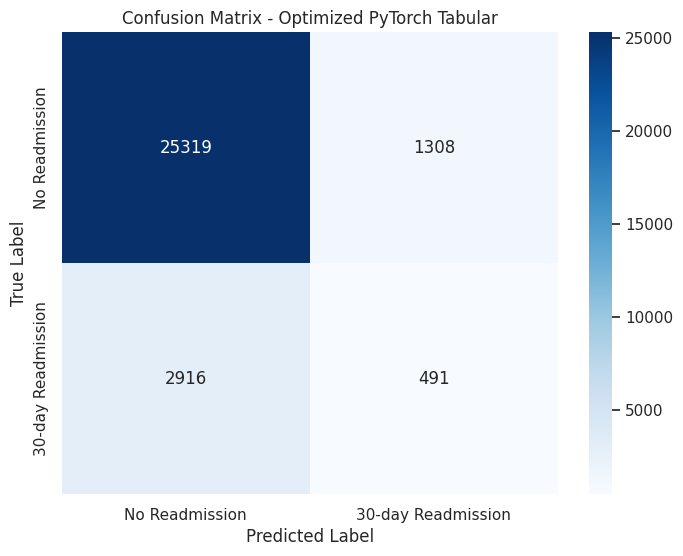


Confusion Matrix (PyTorch Tabular):
True Negatives: 25319
False Positives: 1308
False Negatives: 2916
True Positives: 491


In [58]:
# Save the final PyTorch Tabular model
print("Saving PyTorch Tabular model...")

# Save the model
model_save_path = "best_pytorch_tabular_model"
final_model_pt.save_model(model_save_path)

# Also save the best hyperparameters
with open("best_pytorch_tabular_params.txt", "w") as f:
    f.write("Best PyTorch Tabular Hyperparameters:\n")
    f.write("="*50 + "\n")
    for key, value in study_pt.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nBest CV Accuracy Score: {study_pt.best_value:.4f}\n")
    f.write(f"Final Test Accuracy Score: {final_accuracy_pt:.4f}\n")
    f.write(f"Final Test F1 Score: {final_f1_pt:.4f}\n")
    f.write(f"Final Test ROC-AUC: {final_auc_pt:.4f}\n")

print("Model and parameters saved successfully")

# Create confusion matrix for PyTorch Tabular
cm_pt = confusion_matrix(y_test_pt, final_pred_pt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized PyTorch Tabular')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix (PyTorch Tabular):")
print(f"True Negatives: {cm_pt[0,0]}")
print(f"False Positives: {cm_pt[0,1]}")
print(f"False Negatives: {cm_pt[1,0]}")
print(f"True Positives: {cm_pt[1,1]}")

* The results have slightly worse accuracy than in XGBOOST method. However, the higher recall makes it relatively safer to implement.

In [59]:
# Compare XGBoost and PyTorch Tabular results
print("="*60)
print("MODEL COMPARISON: XGBoost vs PyTorch Tabular")
print("="*60)

print("\nCross-Validation Results (4-fold accuracy scores):")
print(f"XGBoost CV Accuracy:         {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")
print(f"PyTorch Tabular CV Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")

print(f"\nTest Set Performance:")
print(f"{'Metric':<15} {'XGBoost':<10} {'PyTorch Tabular':<15}")
print("-" * 40)
print(f"{'Accuracy':<15} {test_accuracy:.3f}      {final_accuracy_pt:.3f}")
print(f"{'Precision':<15} {test_precision:.3f}      {final_prec_pt:.3f}")
print(f"{'Recall':<15} {test_recall:.3f}      {final_rec_pt:.3f}")
print(f"{'F1':<15} {test_f1:.3f}      {final_f1_pt:.3f}")
print(f"{'ROC-AUC':<15} {test_auc:.3f}      {final_auc_pt:.3f}")

print(f"\nBest Hyperparameters:")
print(f"\nXGBoost:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
    
print(f"\nPyTorch Tabular:")
for key, value in study_pt.best_params.items():
    print(f"  {key}: {value}")

print("\n" + "="*60)

MODEL COMPARISON: XGBoost vs PyTorch Tabular

Cross-Validation Results (4-fold accuracy scores):
XGBoost CV Accuracy:         0.887 ± 0.001
PyTorch Tabular CV Accuracy: 0.636 ± 0.177

Test Set Performance:
Metric          XGBoost    PyTorch Tabular
----------------------------------------
Accuracy        0.887      0.859
Precision       0.533      0.273
Recall          0.059      0.144
F1              0.106      0.189
ROC-AUC         0.784      0.538

Best Hyperparameters:

XGBoost:
  n_estimators: 833
  max_depth: 3
  learning_rate: 0.1053549221246748
  subsample: 0.8579401133870473
  colsample_bytree: 0.8902215020820525
  reg_alpha: 0.9164761833474965
  reg_lambda: 0.5370497367741534

PyTorch Tabular:
  layers_depth: 3
  layer_size: 256
  dropout: 0.07152798695742216
  learning_rate: 0.00825842217004943
  batch_size: 2048
  activation: GELU



* While the accuracy is good, its low recall might make the model unsuitable for deployment yet.

## Model interpretation
* We will use SHAP, a model-agnostic technique to analyze feature contributions the the output.

Performing SHAP analysis on the optimized XGBoost model...
SHAP values computed for 5000 samples


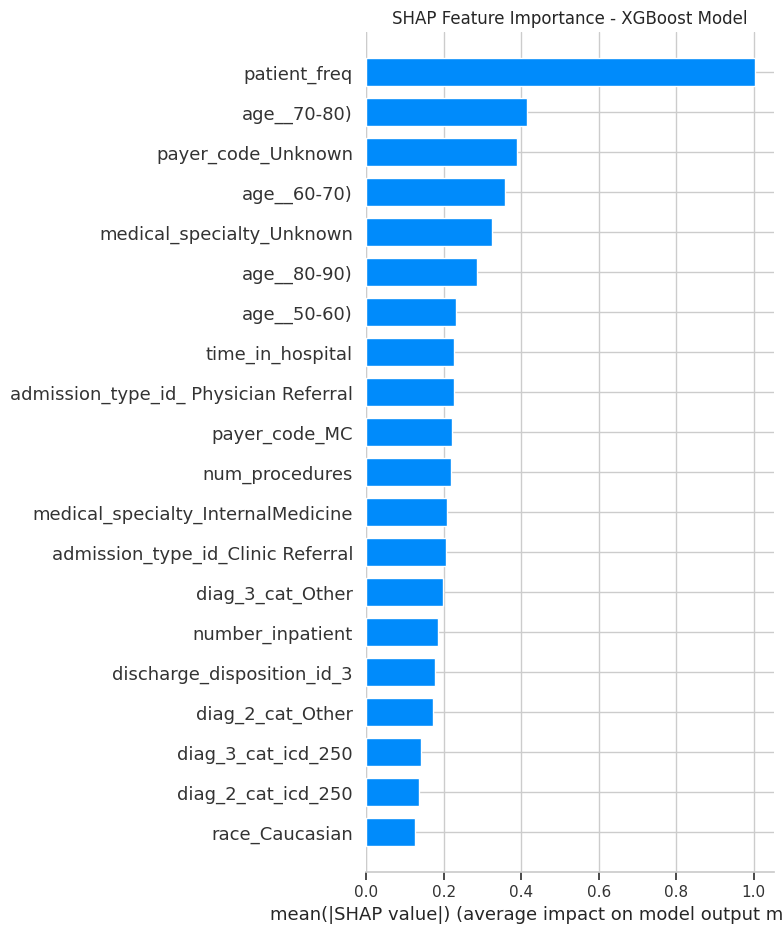

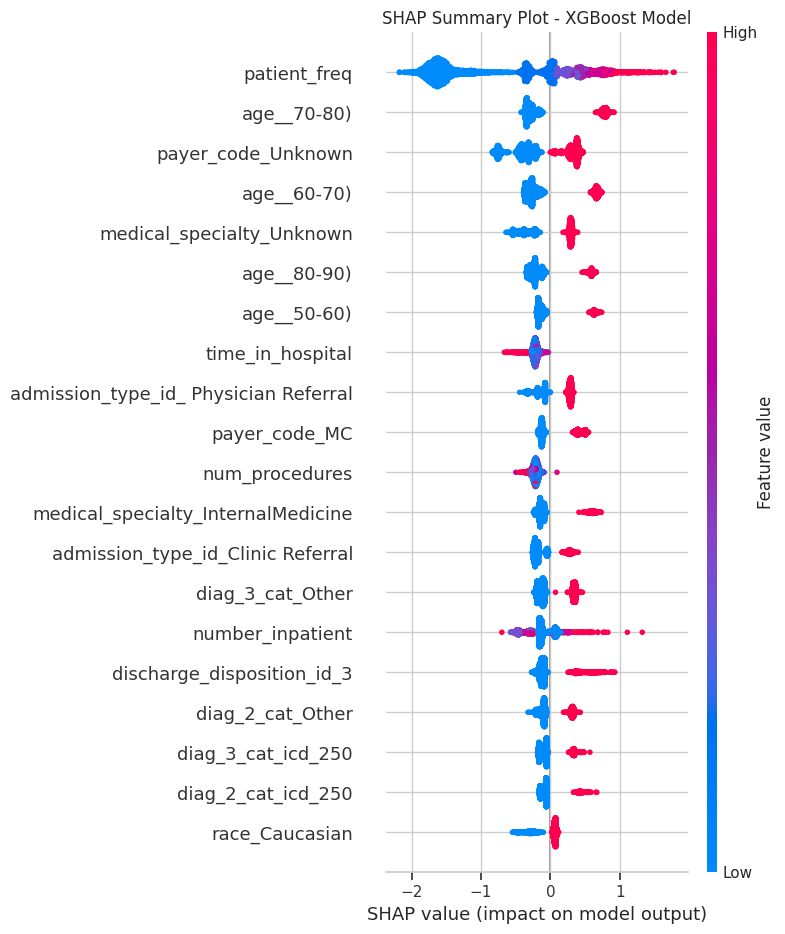


Top 15 Most Important Features (SHAP):
                                   feature  importance
32                            patient_freq    1.001897
45                             age__70-80)    0.414495
92                      payer_code_Unknown    0.388853
44                             age__60-70)    0.356799
163              medical_specialty_Unknown    0.325632
46                             age__80-90)    0.284681
43                             age__50-60)    0.230489
1                         time_in_hospital    0.227223
49   admission_type_id_ Physician Referral    0.226383
83                           payer_code_MC    0.220085
3                           num_procedures    0.219306
110     medical_specialty_InternalMedicine    0.207182
52       admission_type_id_Clinic Referral    0.205343
472                       diag_3_cat_Other    0.197891
7                         number_inpatient    0.186221


In [61]:
# SHAP Analysis for XGBoost Model
print("Performing SHAP analysis on the optimized XGBoost model...")

# Get the XGBoost classifier from the best pipeline
xgb_model = best_pipeline.named_steps['classifier']

# Use a sample of training data for SHAP (to speed up computation)
sample_size = 5000
sample_indices = np.random.choice(X_train.shape[0], size=min(sample_size, X_train.shape[0]), replace=False)
X_sample = X_train.iloc[sample_indices]

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {len(X_sample)} samples")

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - XGBoost Model')
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot - XGBoost Model')
plt.tight_layout()
plt.show()

# Feature importance ranking
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_sample.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (SHAP):")
print(importance_df.head(15))

In [18]:
# Reload the best PyTorch Tabular model
print("Reloading the best PyTorch Tabular model...")

# Load the saved model
final_model_pt = TabularModel.load_model("best_pytorch_tabular_model")

print("Model reloaded successfully!")

Reloading the best PyTorch Tabular model...


2025-06-22 00:12:27,381 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 00:12:27,384 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 00:12:27,387 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 00:12:27,389 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 00:12:27,391 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 00:12:27,393 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 00:12:27,399 - {pytorch_tabular.tabular_model:171} - INFO - Experiment Tracking is turned off

2025-06-22 00:12:27,402 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model reloaded successfully!


In [25]:
# SHAP Analysis for PyTorch Tabular Model
print("Performing SHAP analysis on the optimized PyTorch Tabular model...")

# Create a wrapper function for PyTorch Tabular model predictions
def pytorch_tabular_predict_proba(X):
    """
    Wrapper function to get probability predictions from PyTorch Tabular model
    Returns only the positive class probabilities for SHAP
    """
    # Convert to DataFrame if it's a numpy array
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=X_test_pt.columns)
    else:
        X_df = X.copy()
    
    # Add dummy target column (required by PyTorch Tabular)
    X_df['target'] = 0
    
    # Get predictions
    pred_proba = final_model_pt.predict(X_df)
    
    # Return only positive class probabilities
    return pred_proba['target_1_probability'].values.reshape(-1, 1)

# Use a sample of test data for SHAP (to speed up computation)
background = shap.kmeans(X_train, 100)
# sample_indices = np.random.choice(X_train_pt.shape[0], size=min(sample_size, X_train.shape[0]), replace=False)
# X_sample_pt = X_train_pt.iloc[sample_indices]

# Create SHAP explainer for PyTorch Tabular model
explainer_pt = shap.KernelExplainer(pytorch_tabular_predict_proba, background)  


Performing SHAP analysis on the optimized PyTorch Tabular model...


  0%|          | 0/400 [00:00<?, ?it/s]

SHAP values computed for PyTorch Tabular model


<Figure size 1200x800 with 0 Axes>

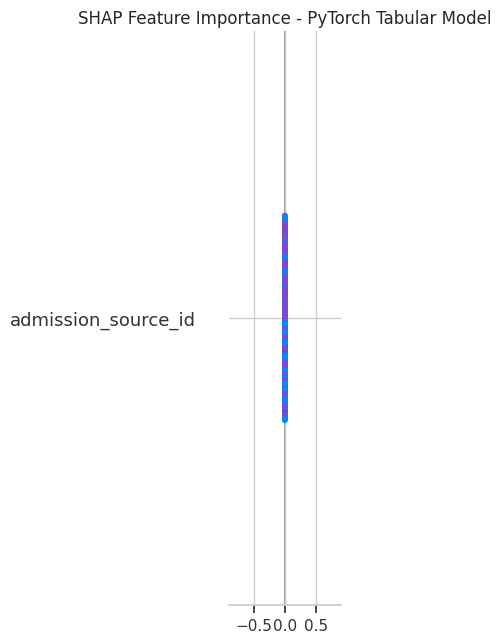

<Figure size 1200x800 with 0 Axes>

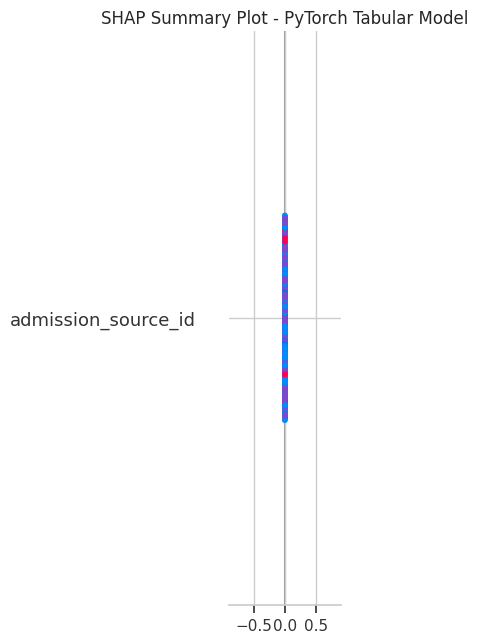

In [26]:
sample_size = 400

sample_indices = np.random.choice(X_train_pt.shape[0], size=min(sample_size, X_train.shape[0]), replace=False)
X_sample_pt = X_train_pt.iloc[sample_indices]

shap_values_pt = explainer_pt.shap_values(X_sample_pt)  # Analyze subset for speed

print(f"SHAP values computed for PyTorch Tabular model")

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_pt, X_sample_pt, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - PyTorch Tabular Model')
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_pt, X_sample_pt, show=False)
plt.title('SHAP Summary Plot - PyTorch Tabular Model')
plt.tight_layout()
plt.show()



In [35]:
# Feature importance ranking for PyTorch Tabular
feature_importance_pt = np.abs(shap_values_pt).mean(0)
feature_names_pt = X_sample_pt.columns
importance_df_pt = pd.DataFrame({
    'feature': feature_names_pt,
    'importance': feature_importance_pt.ravel()
}).sort_values('importance', ascending=False)

print("\nTop 60 Most Important Features (SHAP - PyTorch Tabular):")
importance_df_pt.head(60).to_csv('pytorch_tabular_shap_importance.csv', index=False)


Top 60 Most Important Features (SHAP - PyTorch Tabular):
